## Computer Vision Project - Group 10
#### Daniel Astorino 260799820
#### Murray Kornelsen 260714814
#### Julianna Tchebotareva 260761726
#### Tyler Young 260730324 

In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import math
from sklearn import mixture

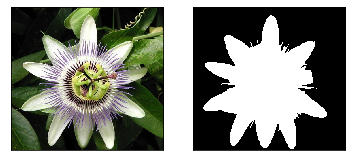

In [25]:
base_imgs = []
validation_imgs = []
base_imgs_filenames = glob.glob("./flower_segmentation/images/*.jpg")
# print(len(base_imgs_filenames))
validation_imgs_filenames = glob.glob("./flower_segmentation/segmentation/*.png")
# print(len(validation_imgs_filenames))

for i in base_imgs_filenames:
#     print(i)
    image = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
    base_imgs.append(image)
    
for i in validation_imgs_filenames:
#     print(i)
    image = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
#     image = cv2.cvtColor(cv2.imread(i), cv2.COLOR_RGB2GRAY)
#     print(image.shape)
    validation_imgs.append(image)

vali_gscaled = [cv2.cvtColor(vali_img, cv2.COLOR_RGB2GRAY) for vali_img in validation_imgs]
vali_gscaled = [np.where(vali_img == 255, 1, 0) for vali_img in vali_gscaled]

plt.subplot(121), plt.imshow(base_imgs[0])
plt.title(""), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(validation_imgs[0])
plt.title(""), plt.xticks([]), plt.yticks([])
plt.show()

[0 0 0 ... 0 0 0]
(265500,)


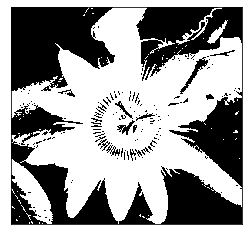

In [26]:
img = base_imgs[0]
# print(img)
reshaped = img.reshape((-1, 3))
# print(reshaped)
gm = mixture.GaussianMixture(n_components = 2, covariance_type = 'spherical',
                                n_init = 1, init_params = "kmeans")

labels = gm.fit_predict(reshaped)
print(labels)
print(labels.shape)

plt.imshow(labels.reshape((500, 531)), cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()

In [27]:
def segment_imgs(base_imgs, covar_type, tolerance, inits):
    segmented_imgs = []
    # original_shapes = []
    gm = mixture.GaussianMixture(n_components = 2, covariance_type = covar_type,
                                 tol = tolerance, n_init = inits, init_params = "kmeans")
    for img in base_imgs:
    #     original_shapes.append((img.shape[0], img.shape[1]))
        labels = gm.fit_predict(img.reshape((-1, 3)))
        segmented_imgs.append(labels.reshape((img.shape[0], img.shape[1])))
    return segmented_imgs

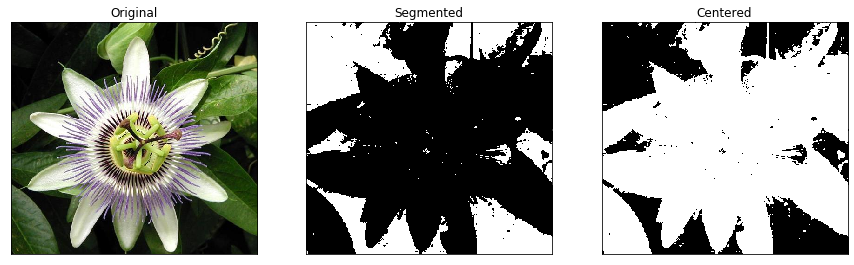

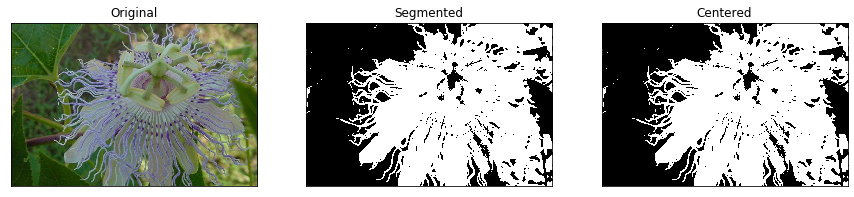

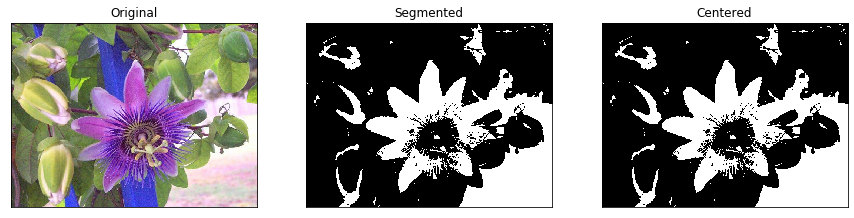

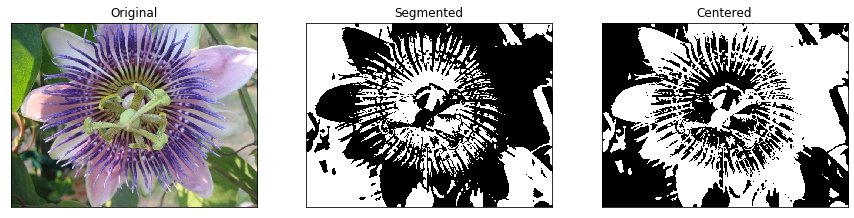

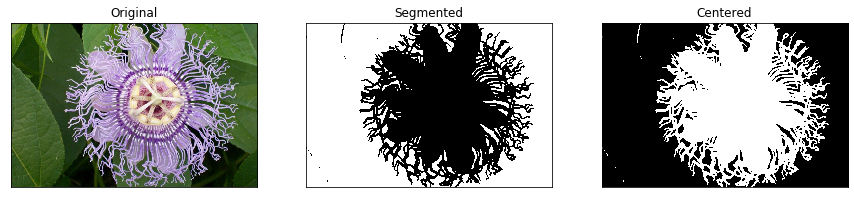

In [29]:
def zero_center(seg_img):
#     print(np.where(seg_img == 0))
    avg0pos = np.mean(np.where(seg_img == 0), axis = 1)
#     print(avg0pos)
#     print(np.array(np.where(seg_img == 0)).shape)
    stdev0pos = np.linalg.norm(np.mean((np.where(seg_img == 0) - avg0pos.reshape(2, 1)) ** 2, axis = 1) ** 0.5)
#     stdev0pos = np.linalg.norm(stdev0pos)
#     print(stdev0pos)
#     stdev0pos = np.mean((np.where(seg_img == 0) - avg0pos.reshape(2, 1)) ** 2) ** 0.5
#     print(stdev0pos)
    avg1pos = np.mean(np.where(seg_img == 1), axis = 1)
#     print(avg1pos)
    stdev1pos = np.linalg.norm(np.mean((np.where(seg_img == 1) - avg1pos.reshape(2, 1)) ** 2, axis = 1) ** 0.5)
#     print(stdev1pos)
    
    if (stdev1pos > stdev0pos):
        seg_img = 1 - seg_img
    return seg_img
    
def center_list(seg_imgs):
    return [zero_center(img) for img in seg_imgs]
# new_img = zero_center(segmented_imgs[1])

# print(new_img.dtype)

# plt.imshow(new_img, cmap = "gray")
# plt.xticks([]), plt.yticks([])
# plt.show()

centered_imgs = center_list(segmented_imgs)

for i in range(5):
    plt.figure(figsize = (15, 5))
    plt.subplot(131), plt.imshow(base_imgs[i])
    plt.title("Original"), plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(segmented_imgs[i], cmap = "gray")
    plt.title("Segmented"), plt.xticks([]), plt.yticks([])
    plt.subplot(133), plt.imshow(centered_imgs[i], cmap = "gray")
    plt.title("Centered"), plt.xticks([]), plt.yticks([])
    plt.show()

In [42]:
def cross_validation(seg_imgs, k):
    dice_results = []
    acc_results = []
    
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for i in range(len(seg_imgs)):
        TP += np.where(np.logical_and(seg_imgs[i] == 1, vali_gscaled[i] == 1))[0].shape[0]
        TN += np.where(np.logical_and(seg_imgs[i] == 0, vali_gscaled[i] == 0))[0].shape[0]
        FP += np.where(np.logical_and(seg_imgs[i] == 1, vali_gscaled[i] == 0))[0].shape[0]
        FN += np.where(np.logical_and(seg_imgs[i] == 0, vali_gscaled[i] == 1))[0].shape[0]
        
        if ((i + 1) % k == 0):
#             if (TP + TN + FP + FN > 0):
            dice_results.append(2 * TP / (2 * TP + FN + FP))
            acc_results.append((TP + TN) / (TP + TN + FP + FN))
        
            TP = 0
            TN = 0
            FP = 0
            FN = 0
#     dice_results.append(2 * TP / (2 * TP + FN + FP))
#     acc_results.append((TP + TN) / (TP + TN + FP + FN))
#         print(tps.shape)
#     print(TP)
#     print(FN)
#     print(FP)
#     DICE = 2 * TP / (2 * TP + FN + FP)
#     print("DICE = " + str(DICE))
    return dice_results, acc_results

# print(centered_imgs[0])
# gscaled = cv2.cvtColor(validation_imgs, cv2.COLOR_RGB2GRAY)
# gscaled = np.where(gscaled == 255, 1, 0)

# print(np.amax(gscaled))
# print(gscaled.shape)
# print(np.where(np.logical_and(segmented_imgs[0] == 1, gscaled[0] == 1))[0].shape)
# print(validation_imgs[0].shape)
# print(np.amax(validation_imgs[0]))

# print(vali_gscaled[0].shape)
# print(np.amax(vali_gscaled[0]))
# DICE_EM = cross_validation(centered_imgs)
# print(DICE_EM)

[0.7954274244785244, 0.8669390139698249, 0.49647051533574327, 0.7174672198780693, 0.8809249488426323, 0.9058489619398684, 0.9477364686565414, 0.71762122196499, 0.7334048700408905, 0.7861980603385696, 0.6360510992632128, 0.889422135645032, 0.9306033970780377, 0.8525878163605295, 0.9268373596614747, 0.9630091380128722, 0.8886341031220403, 0.8018477703629376, 0.9087726494225713, 0.9064947975601643]
0.8276149485967265
0.11566599609945423
0.9630091380128722
0.49647051533574327


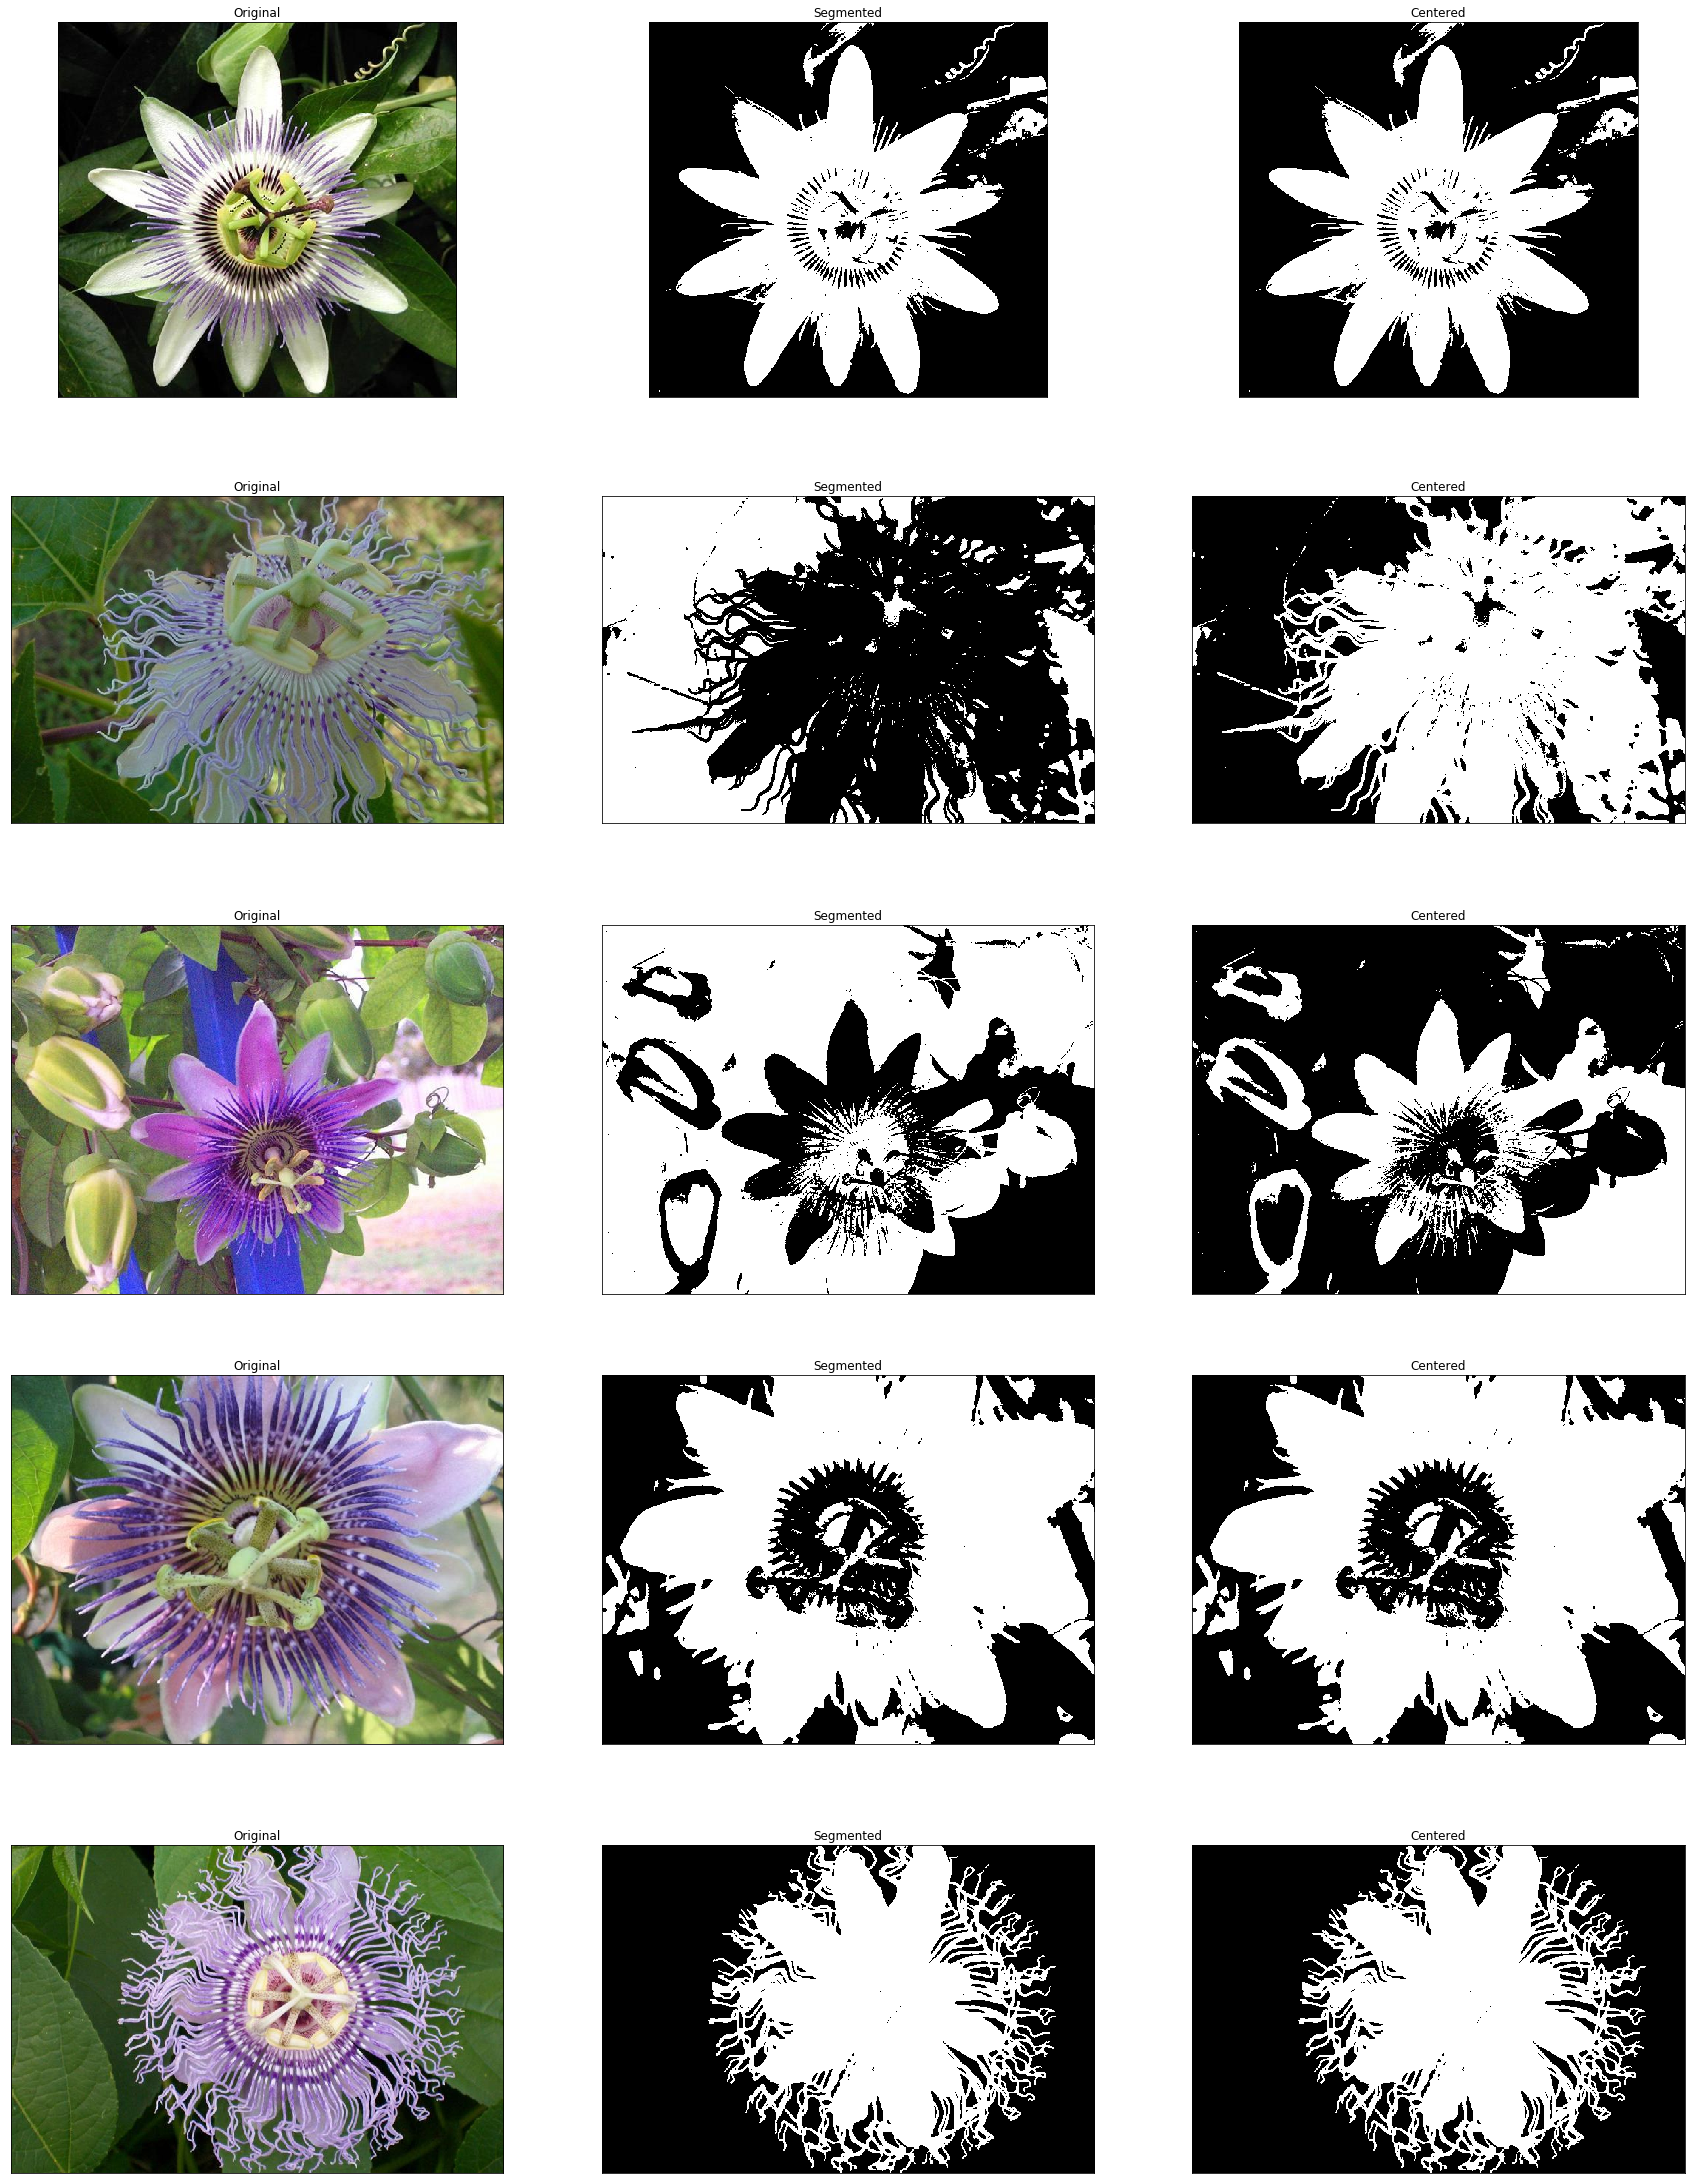

In [51]:
# covar_type = {‘full’ (default), ‘tied’, ‘diag’, ‘spherical’}
segmented_imgs = segment_imgs(base_imgs, 'tied', 1e-4, 3)
centered_imgs = center_list(segmented_imgs)
dice_em, acc_em = cross_validation(centered_imgs, 5)
print(dice_em)
print(np.mean(dice_em))
print(np.std(dice_em))
print(np.amax(dice_em))
print(np.amin(dice_em))
# print(acc_em)
# print(np.mean(acc_em))
# print(len(dice_em))

plt.figure(figsize = (30, 40))
for i in range(5):
    plt.subplot(5, 3, (i * 3) + 1), plt.imshow(base_imgs[i])
    plt.title("Original"), plt.xticks([]), plt.yticks([])
    plt.subplot(5, 3, (i * 3) + 2), plt.imshow(segmented_imgs[i], cmap = "gray")
    plt.title("Segmented"), plt.xticks([]), plt.yticks([])
    plt.subplot(5, 3, (i * 3) + 3), plt.imshow(centered_imgs[i], cmap = "gray")
    plt.title("Centered"), plt.xticks([]), plt.yticks([])
plt.show()